In [73]:
from statsmodels.tsa.arima_process import ArmaProcess 
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from pandas import Series
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import grangercausalitytests

from climate_indices import indices,compute
from climate_indices.indices import Distribution

import PCA_functions as pf

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from statsmodels.tsa.stattools import adfuller
from Data import Data
from datetime import datetime

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import AgglomerativeClustering, DBSCAN

from mpl_toolkits.mplot3d import Axes3D

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

In [3]:
def phase_averaging(data,freq = 12):
    N = len(data)
    temp = data
    result = np.zeros(N)
    averages = np.zeros(freq)
    for j in range(freq):
        Idx = np.arange(j,N,freq)
        averages[j] = temp[Idx].mean()
        result[Idx] = (temp[Idx] - temp[Idx].mean())/temp[Idx].std()
    return(result, averages)

In [4]:
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [82]:
def color_map(lst, cmap):
    result = []
    minima = min(lst)
    maxima = max(lst)

    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    c = mapper.to_rgba(lst)
    
    for i in range(len(lst)):
        result.append('#{:02x}{:02x}{:02x}{:02x}'.format(int(c[i,0]*255), int(c[i,1]*255) , int(c[i,2]*255), int(c[i,3]*255)))
        
    return(result)

In [5]:
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
class_dic = load_obj("class_dic")

In [6]:
def neighbour_vote(df,lat,lon):
    shift = [[-0.25,0,0.25],[-0.25,0,0.25]]
    shift_list = []
    for element in itertools.product(*shift):
        shift_list.append(element)
    shift_list.remove((0,0))
    result = []
    for x,y in shift_list:
        if not df[(df.lats == (lat + y)) & (df.lons == (lon + x))].clusters.values.size == 0:           
            result.append(np.asscalar(df[(df.lats == (lat + y)) & (df.lons == (lon + x))].clusters.values))
        else:
            result.append(-1)   
            
        
    return(np.array(result))

In [7]:
def neighbour_vote_class(dic,lat,lon):
    shift = [[-0.25,0.25],[-0.25,0.25]]
    shift_list = []
    for element in itertools.product(*shift):
        shift_list.append(element)
    #shift_list.remove((0,0))
    result = []
    for x,y in shift_list:
        if lon > 180: lon -= 360
        if (lat + y, lon + x) in class_dic.keys():
            result.append(class_dic[(lat + y, lon + x)])   
    return(np.array(result))

In [8]:
n_components = 5
level = 12
temporal_limits = {"time_min":datetime(1948, 1, 1, 0, 0),"time_max":datetime(2016, 1, 1, 0, 0) } 
spatial_limits = {"lon_min":-40,"lon_max":60,"lat_min":-40,"lat_max":40}

In [28]:
data = np.load('data.npy')
lat = np.load('lat.npy')
lon = np.load('lon.npy')

result = []
index = []
lat_list = []
lon_list =[]

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        #if not np.isnan(data[i,j,-1]):
        if not data[i,j,-1]<0:    
            result.append(data[i,j,:])
            index.append((lon[i],lat[j]))
            lon_list.append(lon[i])
            lat_list.append(lat[j])

In [14]:
data = np.load('spi1_half_48_16.npy')
lat = np.load('lat_half.npy')
lon = np.load('lon_half.npy')

#result = []
index = []
lat_list = []
lon_list =[]

for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if not np.isnan(data[i,j,-1]):
        #if not data[i,j,-1]<0:    
            #result.append(data[i,j,11:])
            index.append((lon[i],lat[j]))
            lon_list.append(lon[i])
            lat_list.append(lat[j])

IndexError: too many indices for array

In [15]:
d = Data('GPCC_half.nc','precip',temporal_limits, missing_value=-9.969209968386869e+36)

#result = d.get_data()
lon_list = d.get_lon_list()
lat_list = d.get_lat_list()
lon = d.get_lon()
lat = d.get_lat()

In [62]:
d = Data('air_daily_africa.nc','air', missing_value=-9.96921e+36)

result_air = d.get_data()
lon_list_air = d.get_lon_list()
lat_list_air = d.get_lat_list()
lon_air = d.get_lon()
lat_air = d.get_lat()

In [29]:
result = pf.deseasonalize(np.array(result))
#result = np.array(result)
#data = pd.DataFrame(result)

In [95]:
result_air = pf.deseasonalize(np.array(result_air), freq=365)
#result = np.array(result)
#data = pd.DataFrame(result)

In [20]:
result = np.array(result)

In [11]:
#just for spi
#result = np.nan_to_num(result)

# TSNE

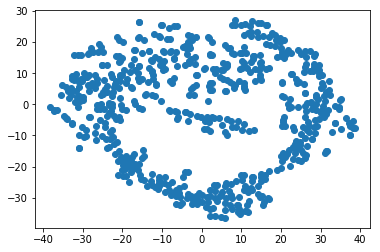

In [30]:
#X_embedded = TSNE(n_components=2,perplexity=80.0).fit_transform(np.transpose(result))
X_embedded = TSNE(n_components=2,perplexity=30.0).fit_transform(result)
#clustering = AgglomerativeClustering(n_clusters=n_components).fit(X_embedded)

fig = plt.figure()
#ax = Axes3D(fig)

vis_x = X_embedded[:, 0]
vis_y = X_embedded[:, 1]
#vis_z = X_embedded[:, 2]
plt.scatter(vis_x, vis_y)
#plt.colorbar(ticks=range(10))
#plt.clim(-0.5, 9.5)
plt.show()

# Clustering

In [54]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(result)
    Sum_of_squared_distances.append(km.inertia_)

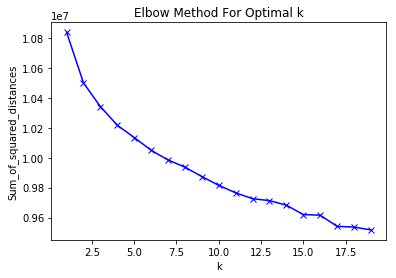

In [55]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [65]:
#dbscan = DBSCAN(eps=0.3, min_samples = 200)
#clusters = dbscan.fit_predict(np.transpose(result))

In [18]:
#temp = np.array(result)
#agg = AgglomerativeClustering(n_clusters=10, affinity='precomputed',linkage = 'average')
#clustering = agg.fit_predict(np.corrcoef(np.transpose(temp)))  # Returns class labels.

In [31]:
clustering = AgglomerativeClustering(n_clusters=n_components).fit(X_embedded)

In [9]:
result = np.load("spi1_half_48_16.npy")

In [10]:
#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result)
#temp = pf.deseasonalize(result)
clustering = AgglomerativeClustering(n_clusters=n_components).fit(np.transpose(temp))

In [75]:
#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result_air)
#temp = pf.deseasonalize(result)
clustering_air = AgglomerativeClustering(n_clusters=n_components).fit(np.transpose(temp))

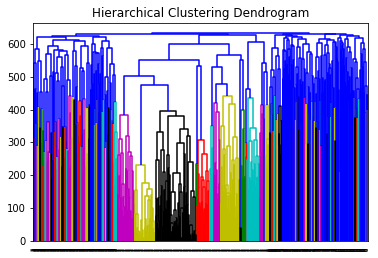

<Figure size 2160x1440 with 0 Axes>

In [23]:
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(clustering, labels=clustering.labels_)
plt.figure(figsize=(30, 20))
plt.show()

In [14]:
#linked = linkage(temp, 'single')

#labelList = range(1, 11)

#plt.figure(figsize=(10, 7))
#dendrogram(linked,
 #           orientation='top',
  #          labels=labelList,
   #         distance_sort='descending',
    #        show_leaf_counts=True)
#plt.show()

In [16]:
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clustering.labels_})

#lon_temp = df["lons"].values
#lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
#df["lons"] = lon_temp

In [24]:
lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

In [20]:
clusters = clustering.labels_

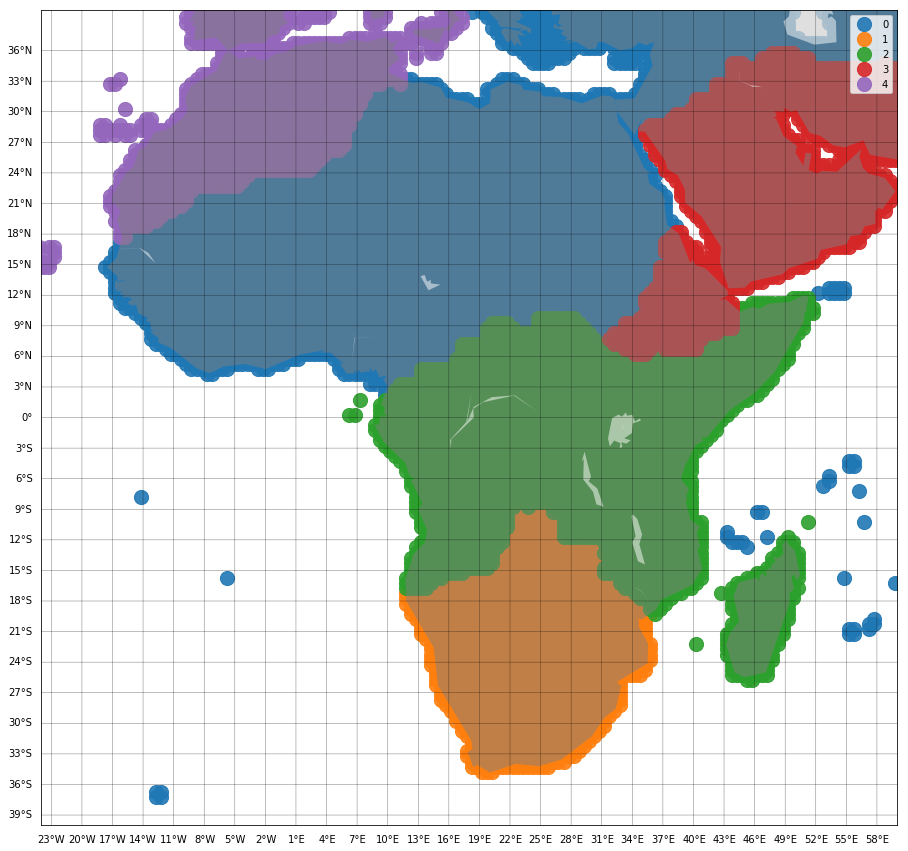

In [25]:
df_list = []
for j in range(len(set(clusters))):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters):
    values = df["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

In [ ]:
clusters_air = clustering_air.labels_

In [81]:
lon1 = np.arange(-40,60.0,2.5)

deg = np.zeros((len(lat_air),len(lon1)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]
combined = []

for i in range(len(clusters_air)):
    r = neighbour_vote(df,lat_list_air[i],lon_list_air[i])       
    if np.all(r == -1):
        clusters_air[i] = -1
    else:
        index = np.argwhere(r == -1)
        r = np.delete(r, index)
        most_common,num_most_common = Counter(r).most_common(1)[0]
        clusters_air[i] = clusters_air[i]*10 + most_common
        #df_air[(df_air.lats == lat_air[i]) & (df_air.lons == lon1[j])].clusters = np.asscalar(df_air[(df_air.lats == lat_air[i]) & (df_air.lons == lon1[j])].clusters.values)*10 + most_common
        #deg[i,j] = np.asscalar(df_air[(df_air.lats == lat_air[i]) & (df_air.lons == lon1[j])].clusters.values)*10 + most_common


In [82]:
index = np.argwhere(clusters_air == -1)

clusters_air = np.delete(clusters_air, index)
lat_list_air = np.delete(lat_list_air, index)
lon_list_air = np.delete(lon_list_air, index)

In [83]:
df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clusters_air})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"] = lon_temp

In [17]:
df_list = []
for j in range(len(set(clusters_air))):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

NameError: name 'clusters_air' is not defined

In [85]:
class_air = []
for i in range(len(clusters_air)):
    r = neighbour_vote_class(df,lat_list_air[i],lon_list_air[i])  
    if r.size == 0:
        class_air.append('NAN')
    else:
        most_common,num_most_common = Counter(r).most_common(1)[0]
        class_air.append(most_common)

In [86]:
from sklearn.metrics.cluster import adjusted_mutual_info_score,homogeneity_score, mutual_info_score, adjusted_rand_score

In [87]:
mutual_info_score(clusters_air, class_air)

1.0674602270841609

In [88]:
adjusted_mutual_info_score(clusters_air, class_air)

0.4272369628748989

In [89]:
homogeneity_score(clusters_air, class_air)

0.46964076120924114

In [90]:
adjusted_rand_score(clusters_air, class_air)

0.4515822080112592

In [347]:
df_air = pd.DataFrame({"lons":lon_list_air,"lats":lat_list_air,"clusters":clusters_air})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"] = lon_temp

In [24]:
lon1 = np.arange(-40,60.0,2.5)

deg = np.zeros((len(lat_air),len(lon1)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_air[(df_air.lats == lat_air[i]) & (df_air.lons == lon1[j])].clusters.values.size == 0:
            
            deg[i,j] = df_air[(df_air.lats == lat_air[i]) & (df_air.lons == lon1[j])].clusters.values
        else:
            deg[i,j]=np.nan

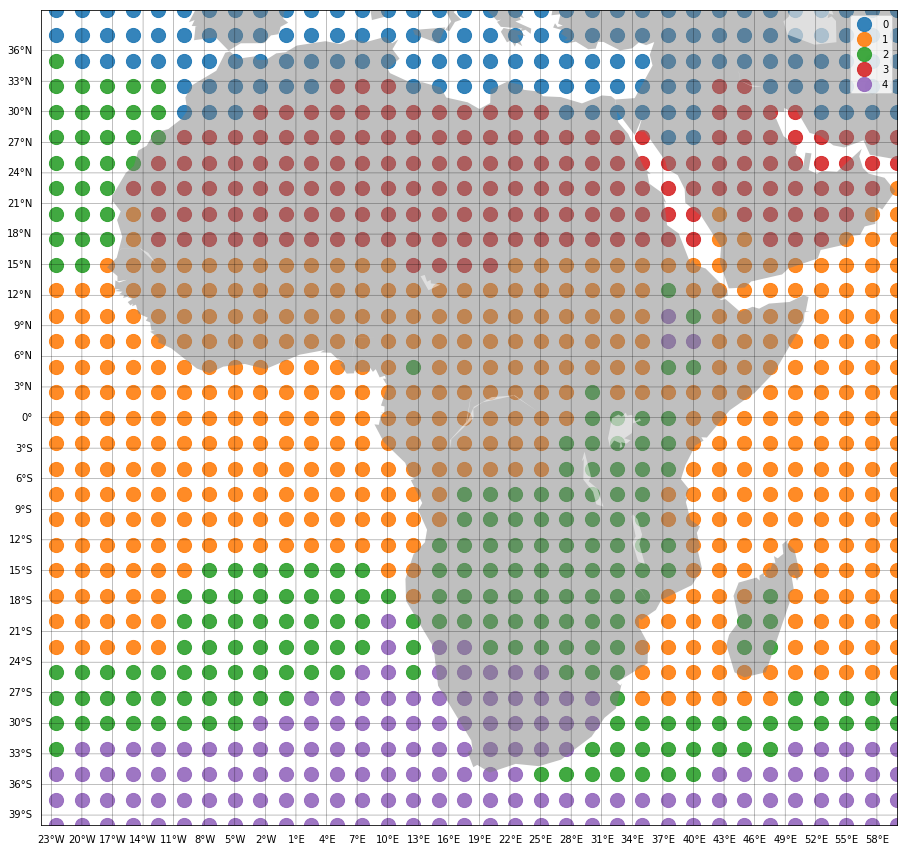

In [72]:
df_list = []
for j in range(len(set(clusters_air))):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)
#m.drawcoastlines()
#colors = pf.random_color_1(n_components)

i = 0
for j in set(clusters_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == j)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)
    i+=1

    
plt.legend()
plt.show()

In [32]:
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clustering.labels_})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

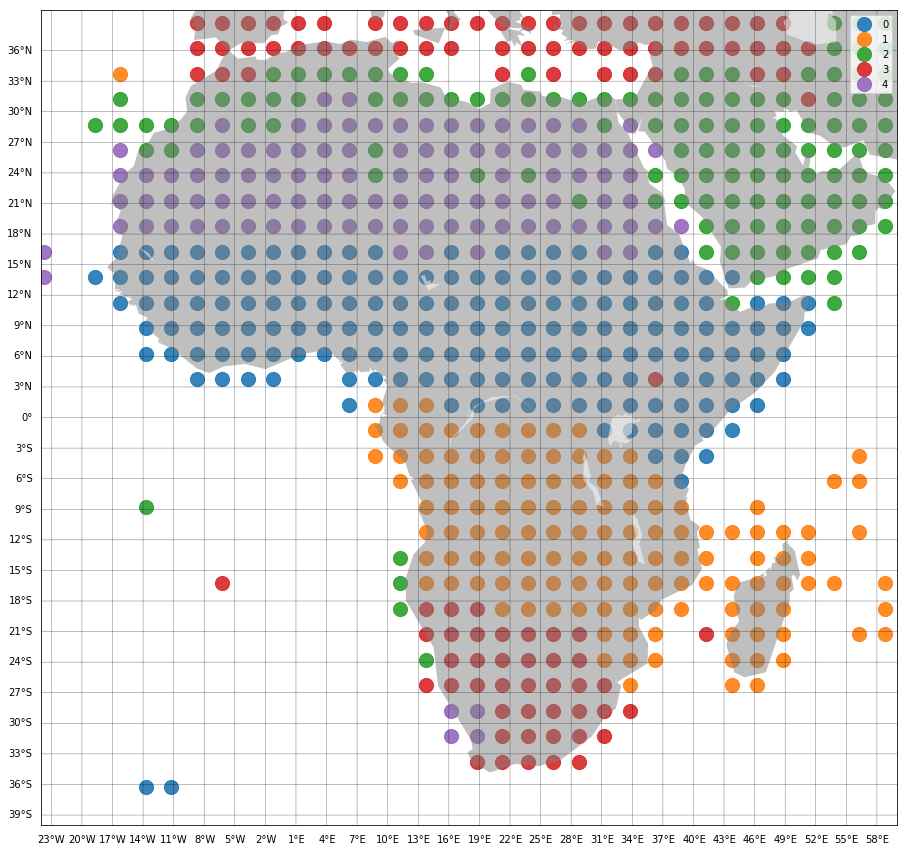

In [33]:
df_list = []
for j in range(n_components):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)

#colors = pf.random_color_1(n_components)

for i in range(n_components):
    values = df["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=200, label = i)

    
plt.legend()
plt.show()

In [ ]:
df = pd.DataFrame({"lons":lon_list,"lats":lat_list,"clusters":clustering.labels_})

lon_temp = df["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df["lons"] = lon_temp

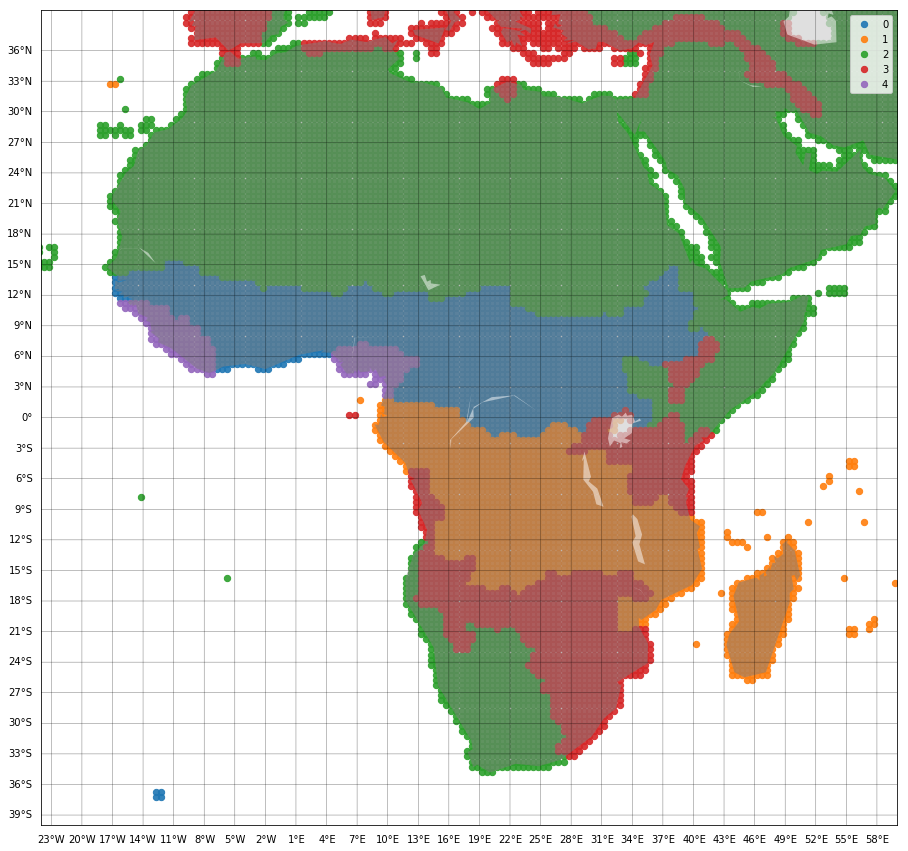

In [72]:
df_list = []
for j in range(n_components):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)

#colors = pf.random_color_1(n_components)

for i in range(n_components):
    values = df["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=40, label = i)

    
plt.legend()
plt.show()

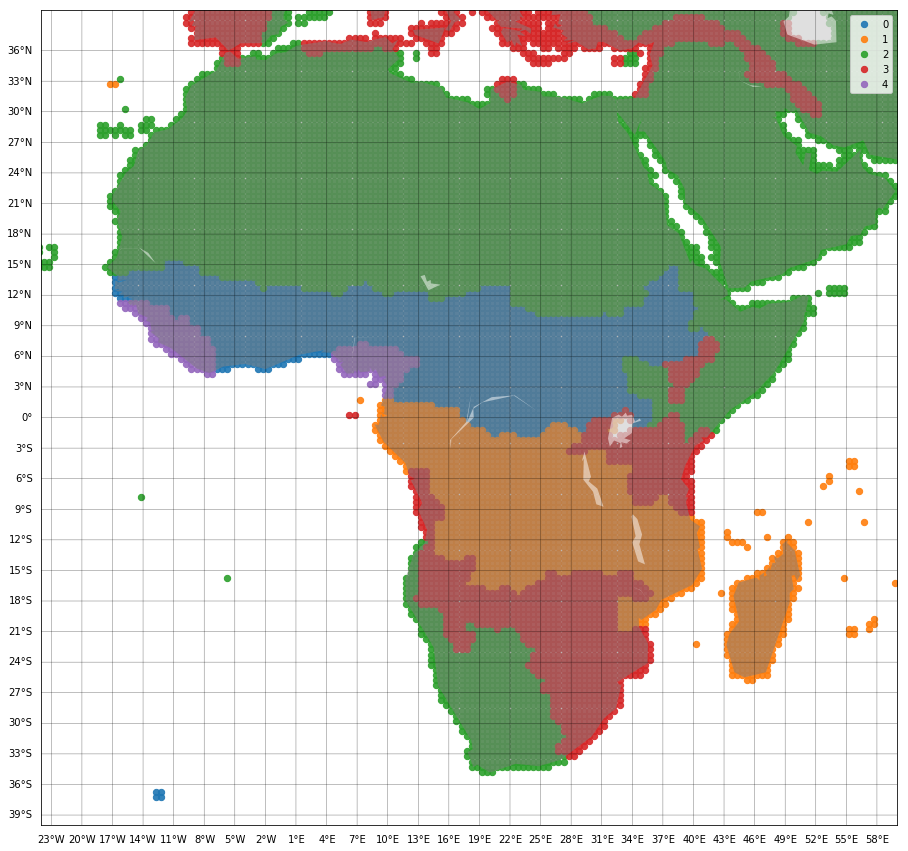

In [53]:
df_list = []
for j in range(n_components):
    df_list.append(pd.DataFrame(columns=df.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m = Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
m.fillcontinents(color='grey', alpha=0.5)
m.drawparallels(np.arange(int(-39.75),int(39.75),3),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-29.75),int(59.75),3),labels=[0,0,0,1],linewidth=0.5)

#colors = pf.random_color_1(n_components)

for i in range(n_components):
    values = df["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=40, label = i)

    
plt.legend()
plt.show()

In [ ]:

plt.figure(figsize=(30,15))
# Make the background map
m=Basemap(llcrnrlon=-24, llcrnrlat=-40,urcrnrlon=60,urcrnrlat=40)
#m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawcoastlines()
xx, yy = meshgrid(lon1, lat_air)
cs = m.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
#cs = map.contourf(xx, yy, deg, 11, cmap=plt.cm.Spectral_r)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.set_label('clusters')
#plt.title("Autoregressive Levels"

In [ ]:
lon1 = np.arange(-40,60.0,2.5)

deg = np.zeros((len(lat_air),len(lon1)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]
combined = []

for i in range(lat_number):
    for j in range(lon_number):
        if not df_air[(df_air.lats == lat_air[i]) & (df_air.lons == lon1[j])].clusters.values.size == 0:
            r = neighbour_vote(df,lat_air[i],lon1[j])
            index = df_air[(df_air.lats == lat_air[i]) & (df_air.lons == lon1[j])].index.tolist()[0]
            if np.all(r == -1):
                deg[i,j]=np.nan
                df.loc[index].clusters = np.nan
            else:
                index = np.argwhere(r == -1)
                r = np.delete(r, index)
                most_common,num_most_common = Counter(r).most_common(1)[0]
                clusters_air[index] = np.asscalar(df_air[(df_air.lats == lat_air[i]) & (df_air.lons == lon1[j])].clusters.values)*10 + most_common
                #df_air[(df_air.lats == lat_air[i]) & (df_air.lons == lon1[j])].clusters = np.asscalar(df_air[(df_air.lats == lat_air[i]) & (df_air.lons == lon1[j])].clusters.values)*10 + most_common
                deg[i,j] = np.asscalar(df_air[(df_air.lats == lat_air[i]) & (df_air.lons == lon1[j])].clusters.values)*10 + most_common
        else:
            deg[i,j]=np.nan

In [ ]:
#shift_list = []
#for element in itertools.product(*shift):
#    shift_list.append(element)

# PCA for each clusters

In [26]:
cluster_data = []
for i in range(n_components):
    Idx = np.where((df.clusters == i).values)[0]
    r = result[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_data.append(pca_data[:,0])

In [27]:
df_cluster = pd.DataFrame(np.transpose(np.matrix(cluster_data)))

In [24]:
#df_cluster

In [71]:
pca_model.explained_variance_ratio_

array([0.21961581, 0.07618791, 0.05826201, 0.04551627, 0.03035247,
       0.02833118, 0.02552378, 0.02303025, 0.01979853, 0.01804918])

In [28]:
var_names = df_cluster.columns

#pca_data = pca_model.transform(data)
#pca_data = result.dot(loading)
pca_data = np.matrix(df_cluster)

dataframe = pp.DataFrame(pca_data,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [29]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.05)


## Significant links at alpha = 0.05:

    Variable 0 has 6 link(s):
        (4 0): pval = 0.00000 | val = 0.344
        (3 0): pval = 0.00000 | val = 0.249
        (0 -1): pval = 0.00000 | val = 0.234
        (2 -1): pval = 0.00212 | val = -0.108
        (2 0): pval = 0.02389 | val = 0.080
        (4 -1): pval = 0.04772 | val = 0.070

    Variable 1 has 4 link(s):
        (1 -1): pval = 0.00000 | val = 0.233
        (2 -1): pval = 0.00465 | val = 0.100
        (3 0): pval = 0.02364 | val = -0.080
        (3 -2): pval = 0.03164 | val = -0.076

    Variable 2 has 6 link(s):
        (3 0): pval = 0.00000 | val = 0.314
        (2 -1): pval = 0.00000 | val = 0.280
        (4 0): pval = 0.00247 | val = 0.107
        (0 0): pval = 0.02389 | val = 0.080
        (2 -2): pval = 0.03595 | val = 0.074
        (3 -1): pval = 0.04675 | val = 0.070

    Variable 3 has 7 link(s):
        (2 0): pval = 0.00000 | val = 0.314
        (0 0): pval = 0.00000 | val = 0.249
        (4 0): pval = 0.00000 | v

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f10d43a5978>)

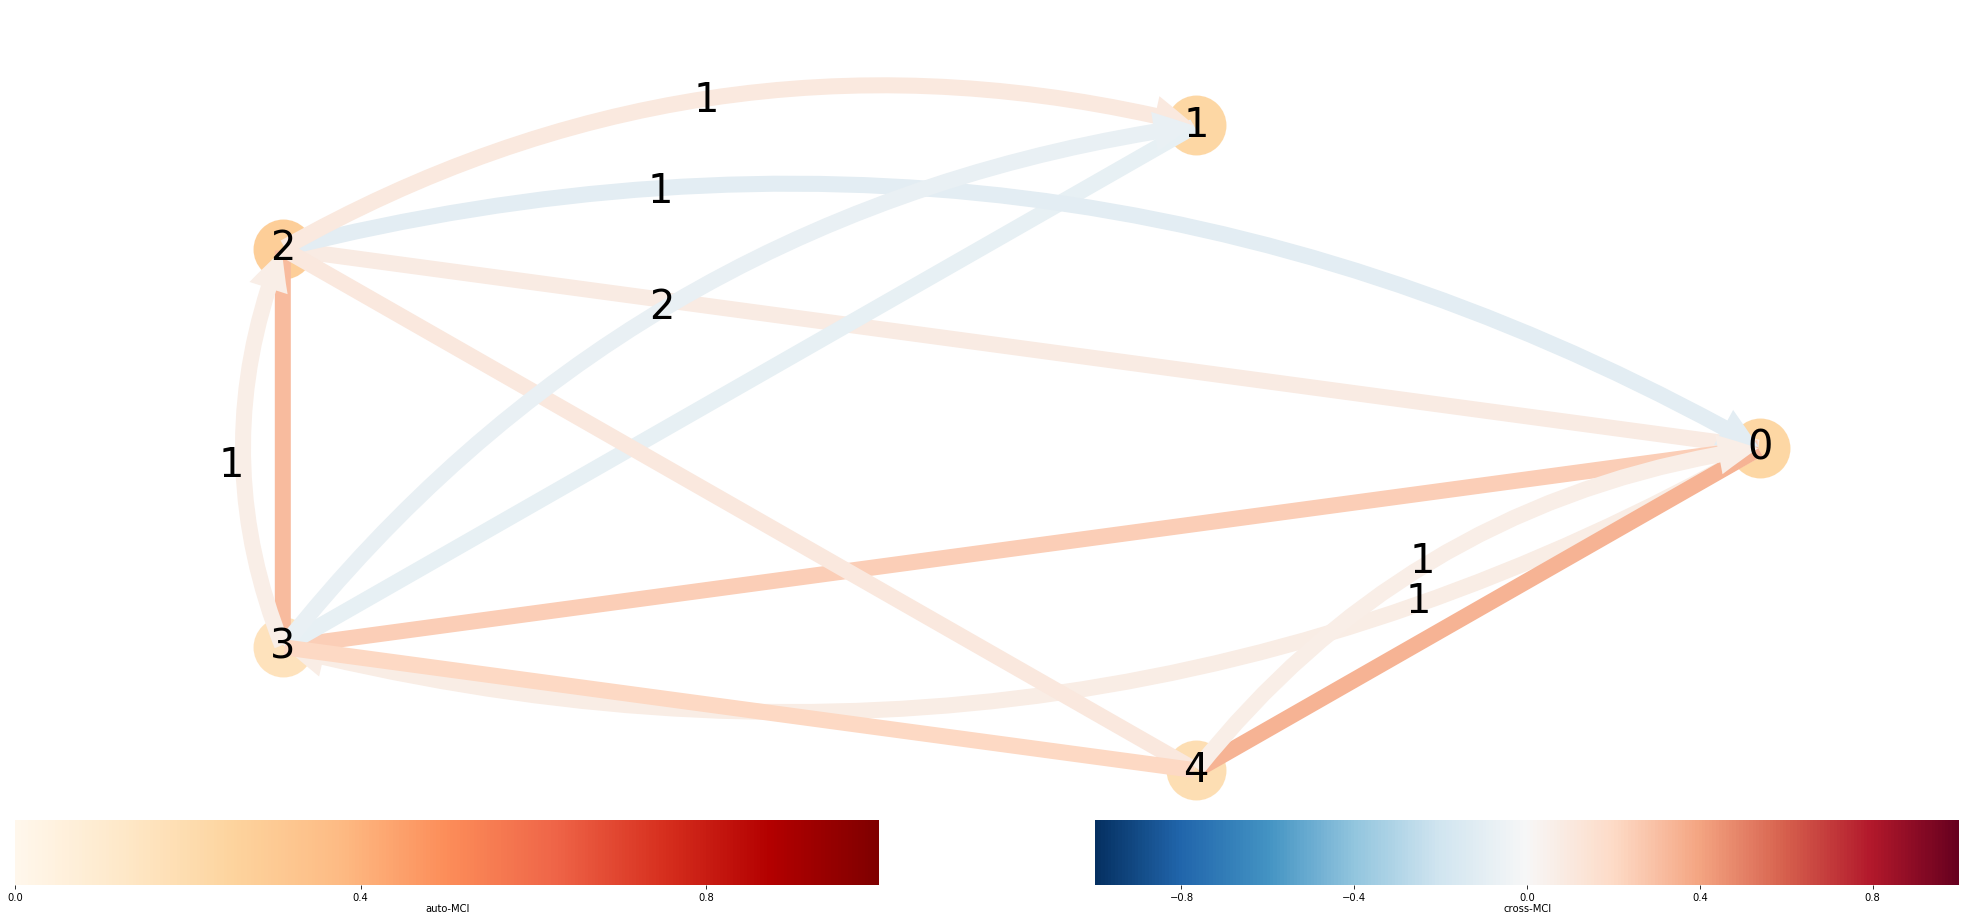

In [30]:
link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 80
    )

In [31]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable 0 has 3 link(s):
        (4 0): pval = 0.00000 | qval = 0.00000 | val = 0.344
        (3 0): pval = 0.00000 | qval = 0.00000 | val = 0.249
        (0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.234

    Variable 1 has 1 link(s):
        (1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.233

    Variable 2 has 3 link(s):
        (3 0): pval = 0.00000 | qval = 0.00000 | val = 0.314
        (2 -1): pval = 0.00000 | qval = 0.00000 | val = 0.280
        (4 0): pval = 0.00247 | qval = 0.00247 | val = 0.107

    Variable 3 has 4 link(s):
        (2 0): pval = 0.00000 | qval = 0.00000 | val = 0.314
        (0 0): pval = 0.00000 | qval = 0.00000 | val = 0.249
        (4 0): pval = 0.00000 | qval = 0.00000 | val = 0.208
        (3 -1): pval = 0.00000 | qval = 0.00004 | val = 0.162

    Variable 4 has 4 link(s):
        (0 0): pval = 0.00000 | qval = 0.00000 | val = 0.344
        (3 0): pval = 0.00000 | qval = 0.00000 | val = 0.208
        (

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f10d56a3e10>)

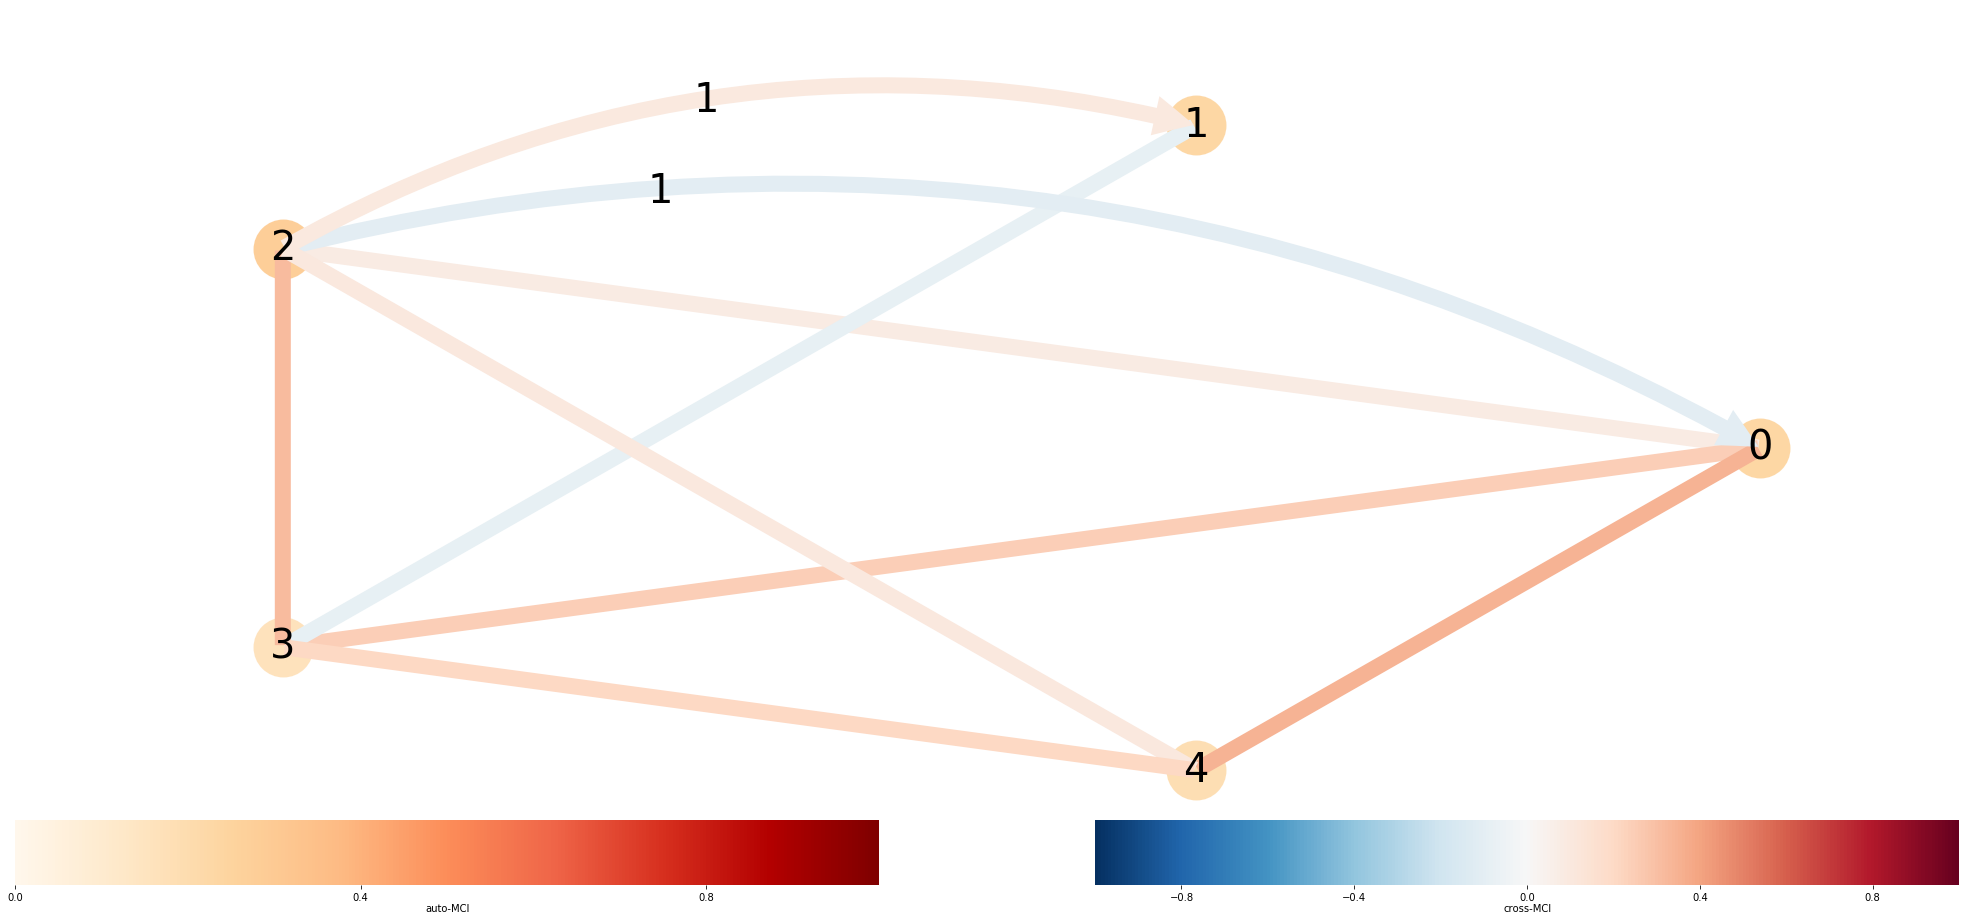

In [32]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.05)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 80
    )

# Adding SST

In [22]:
sst = Data('sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result_sst = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst = pf.deseasonalize(np.array(result_sst))
data_sst = pd.DataFrame(result_sst)

#result_sst = pf.deseasonalize(np.array(result_sst))
n_components_sst = 10


scale = StandardScaler()
scaled_data = scale.fit_transform(data_sst)

pca = PCA(n_components=n_components_sst)
pca_model = pca.fit(scaled_data)

#pca_data = pca_model.transform(data)

#Matrix = pd.DataFrame(pca_model.components_)
#Matrix1 = np.transpose(Matrix)

Matrix = np.transpose(pca_model.components_)
#Matrix1 = Matrix1/Matrix1.sum(axis=0)
#Matrix = Matrix/Matrix.sum(axis=0)
#Matrix, R, indx = orthomax(Matrix)


loading_sst = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading_sst = pd.DataFrame(Matrix)
#loading = pd.DataFrame(Matrix)
#loading = loading.abs()
#loading = loading/loading.sum()

clusters = loading_sst.idxmax(axis=1)
df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list,"clusters":clusters.values.tolist()})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

# Adding SST (Clustering)

In [112]:
n_components_sst = 50

sst = Data('sst.mnmean.nc','sst',temporal_limits, missing_value= -9.96921e+36)

result_sst = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst = pf.deseasonalize(np.array(result_sst))

#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result_sst)
#temp = pf.deseasonalize(result)
clustering = AgglomerativeClustering(n_clusters=n_components_sst).fit(np.transpose(temp))

df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list,"clusters":clustering.labels_})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

cluster_sst = []
for i in range(n_components_sst):
    Idx = np.where((df_sst.clusters == i).values)[0]
    r = result_sst[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components_sst)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_sst.append(pca_data[:,0])

df_cluster_sst = pd.DataFrame(np.transpose(np.matrix(cluster_sst)))

In [113]:
import matplotlib
import matplotlib.cm as cm

lst = np.arange(0,18,1)

minima = min(lst)
maxima = max(lst)

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Greys_r)

for v in lst:
    print(mapper.to_rgba(v))

(0.0, 0.0, 0.0, 1.0)
(0.06828143021914648, 0.06828143021914648, 0.06828143021914648, 1.0)
(0.13656286043829297, 0.13656286043829297, 0.13656286043829297, 1.0)
(0.21776239907727796, 0.21776239907727796, 0.21776239907727796, 1.0)
(0.3008073817762399, 0.3008073817762399, 0.3008073817762399, 1.0)
(0.36724336793540946, 0.36724336793540946, 0.36724336793540946, 1.0)
(0.42814302191464815, 0.42814302191464815, 0.42814302191464815, 1.0)
(0.49134948096885817, 0.49134948096885817, 0.49134948096885817, 1.0)
(0.5559400230680508, 0.5559400230680508, 0.5559400230680508, 1.0)
(0.6242214532871972, 0.6242214532871972, 0.6242214532871972, 1.0)
(0.6961937716262976, 0.6961937716262976, 0.6961937716262976, 1.0)
(0.7605536332179931, 0.7605536332179931, 0.7605536332179931, 1.0)
(0.8122260668973471, 0.8122260668973471, 0.8122260668973471, 1.0)
(0.8615916955017301, 0.8615916955017301, 0.8615916955017301, 1.0)
(0.9040369088811995, 0.9040369088811995, 0.9040369088811995, 1.0)
(0.9446366782006921, 0.94463667820069

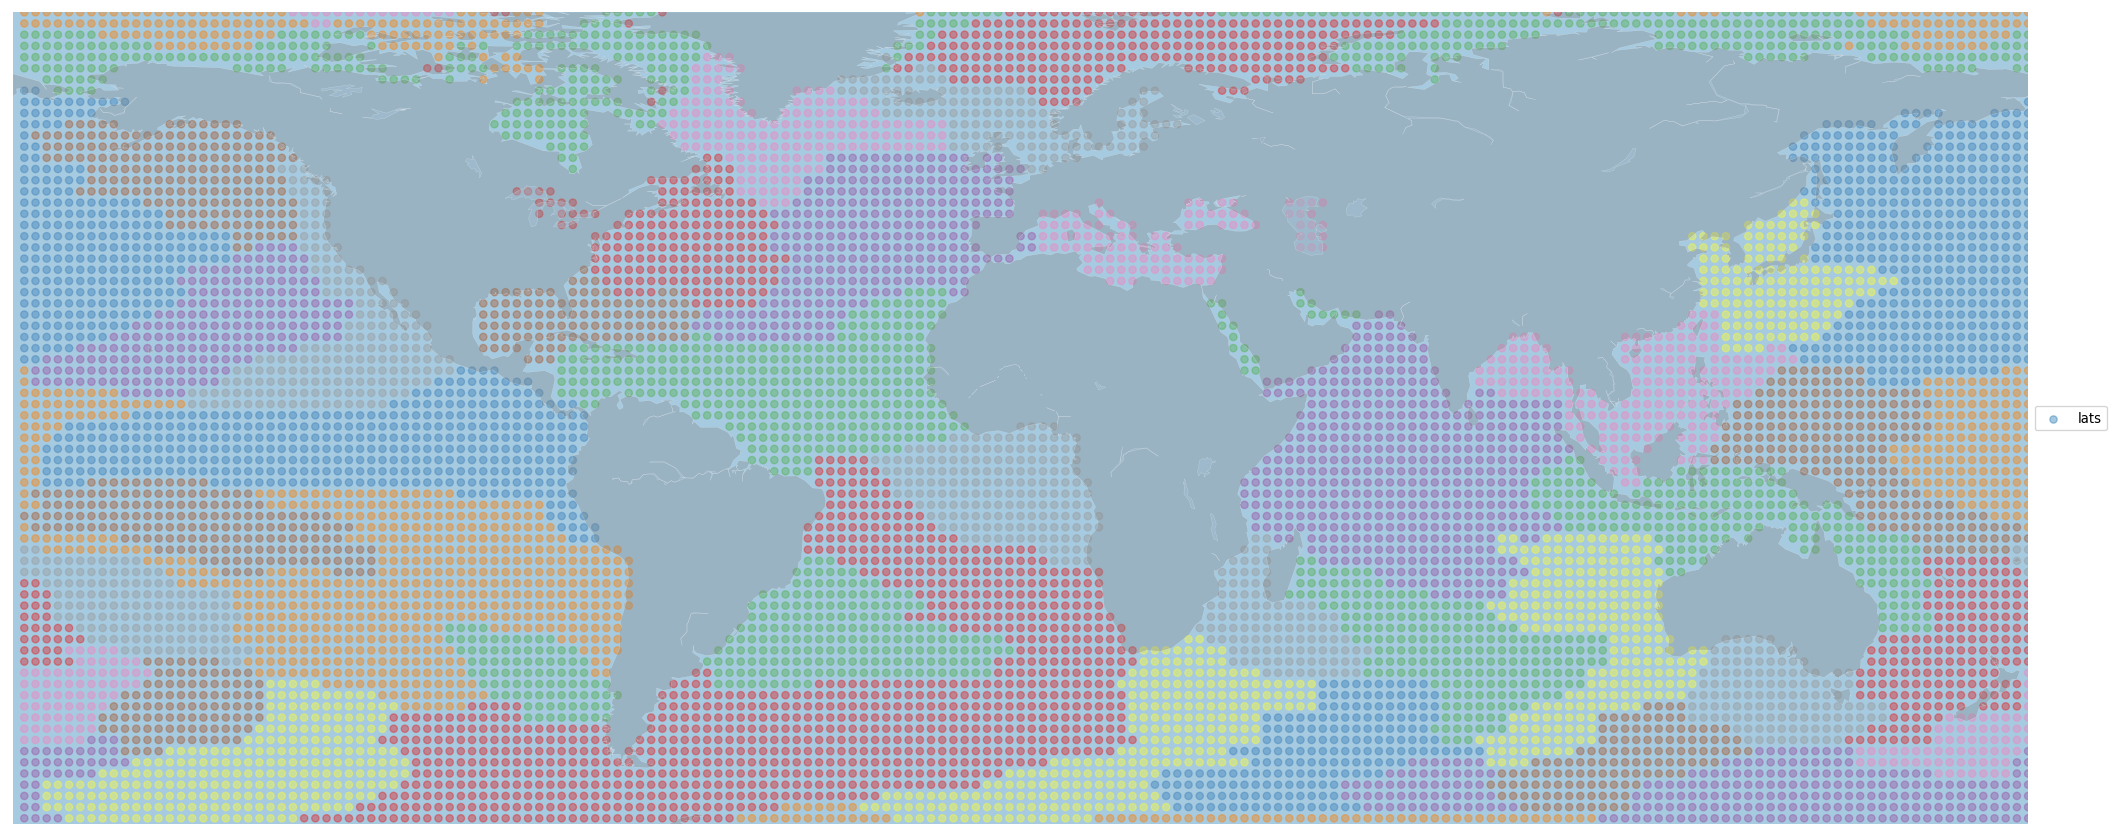

In [115]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
 
# Set the dimension of the figure
my_dpi=96
plt.figure(figsize=(2600/my_dpi, 1800/my_dpi), dpi=my_dpi)
 
# read the data (on the web)
#data = pd.read_csv('http://python-graph-gallery.com/wp-content/uploads/TweetSurfData.csv', sep=";")
 
# Make the background map
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.3)
m.drawcoastlines(linewidth=0.1, color="white")
 
# prepare a color for each point depending on the continent.
#df_sst['labels_enc'] = pd.factorize(data['homecontinent'])[0]
 
# Add a point per position
m.scatter(df_sst['lons'], df_sst['lats'], s=30, alpha=0.4, c=df_sst['clusters'], cmap="Set1")
 
# copyright and source data info
#plt.text( -170, -58,'Where people talk about #Surf\n\nData collected on twitter by @R_Graph_Gallery during 300 days\nPlot realized with Python and the Basemap library', ha='left', va='bottom', size=9, color='#555555' )
 
# Save as png
#plt.savefig('#315_Tweet_Surf_Bubble_map1.png', bbox_inches='tight')
#box = ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#for a in [100, 300, 500]:
#    plt.scatter([], [], c='k', alpha=0.5, s=a,
#                label=str(a) + ' km$^2$')
#plt.legend(scatterpoints=1, frameon=False,
#           labelspacing=1, loc='lower left');

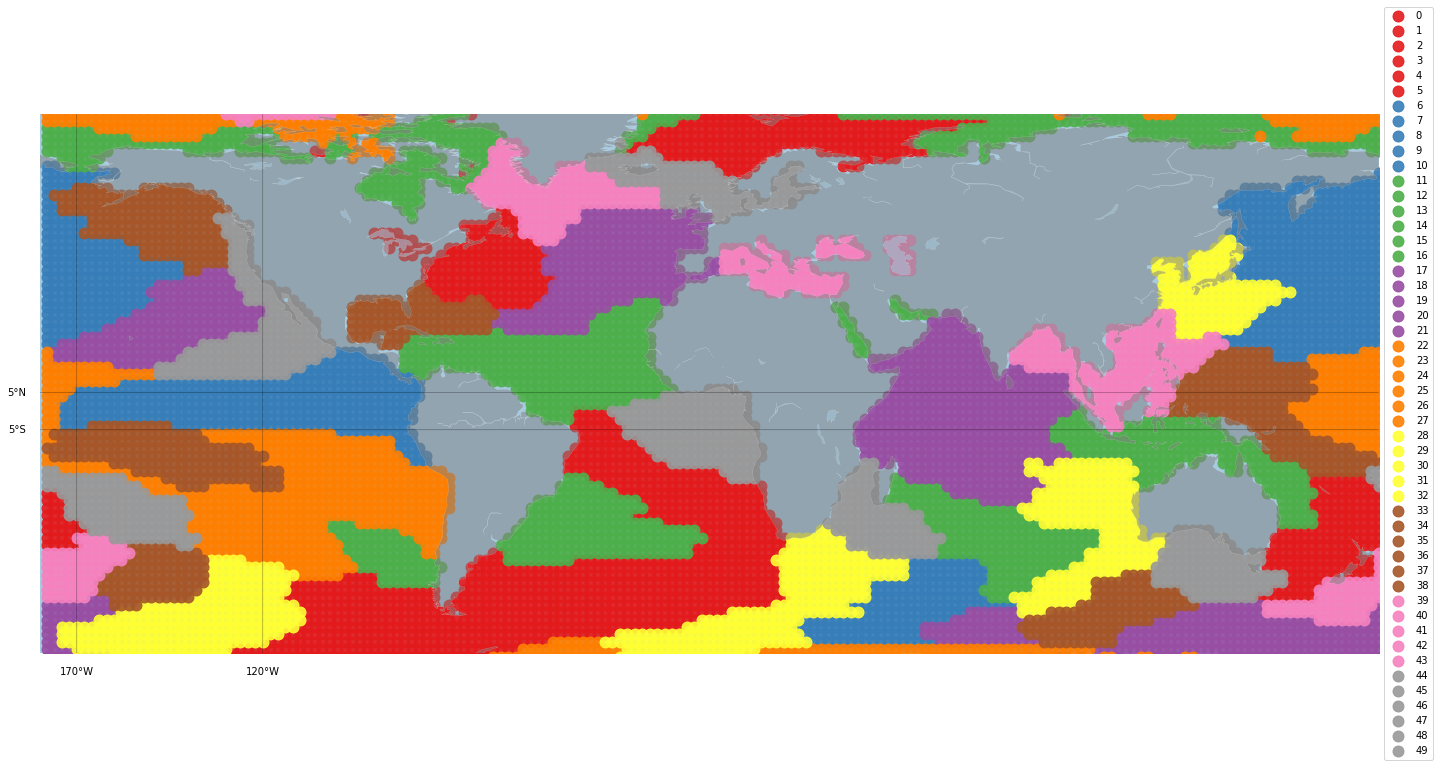

In [114]:
df_list = []
for j in range(n_components_sst):
    df_list.append(pd.DataFrame(columns=df_sst.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")
m.drawparallels(np.arange(int(-5),int(10),10),labels=[1,0,0,0],linewidth=0.5)
m.drawmeridians(np.arange(int(-170),int(-80),50),labels=[0,0,0,1],linewidth=0.5)

#colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
#'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
#'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

#colors = ['#fff7fb', '#ece7f2', '#d0d1e6', '#a6bddb', '#74a9cf', 
#'#3690c0', '#0570b0', '#045a8d', '#023858', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
#'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

colors = color_map(np.arange(0,n_components_sst,1),cm.Set1)
#'#{:02x}{:02x}{:02x}{:02x}'.format( 120, 0 , 255, 128 )

#colors = pf.random_color(n_components_sst)

for i in range(n_components_sst):
    values = df_sst["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df_sst.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=120, label = i, c = colors[i])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
#plt.legend()
plt.show()

# Adding Air pressure

In [23]:
pres = Data('pres.mon.mean.nc','pres',temporal_limits, missing_value= -9.96921e+36)

result_pres = pres.get_data()
lon_pres_list = pres.get_lon_list()
lat_pres_list = pres.get_lat_list()
lon_pres = pres.get_lon()
lat_pres = pres.get_lat()

result_pres = pf.deseasonalize(np.array(result_pres))
data_pres = pd.DataFrame(result_pres)

#result_pres = pf.deseasonalize(np.array(result_pres))
n_components_pres = 10


scale = StandardScaler()
scaled_data = scale.fit_transform(data_pres)

pca = PCA(n_components=n_components_pres)
pca_model = pca.fit(scaled_data)

Matrix = np.transpose(pca_model.components_)
#Matrix = Matrix/Matrix.sum(axis=0)


loading_pres = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading_pres = pd.DataFrame(Matrix)

clusters = loading_pres.idxmax(axis=1)
df_pres = pd.DataFrame({"lons":lon_pres_list,"lats":lat_pres_list,"clusters":clusters.values.tolist()})

lon_temp = df_pres["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_pres["lons"].vlues = lon_temp

# Adding Air pressure (Clustering)

In [15]:
n_components_pres = 20

pres = Data('pres.mon.mean.nc','pres',temporal_limits, missing_value= -9.96921e+36)

result_pres = pres.get_data()
lon_pres_list = pres.get_lon_list()
lat_pres_list = pres.get_lat_list()
lon_pres = pres.get_lon()
lat_pres = pres.get_lat()

result_pres = pf.deseasonalize(np.array(result_pres))

#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result_pres)
#temp = pf.deseasonalize(result)
clustering = AgglomerativeClustering(n_clusters=n_components_pres).fit(np.transpose(temp))

df_pres = pd.DataFrame({"lons":lon_pres_list,"lats":lat_pres_list,"clusters":clustering.labels_})

lon_temp = df_pres["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_pres["lons"].vlues = lon_temp

cluster_pres = []
for i in range(n_components_pres):
    Idx = np.where((df_pres.clusters == i).values)[0]
    r = result_pres[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components_pres)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_pres.append(pca_data[:,0])

df_cluster_pres = pd.DataFrame(np.transpose(np.matrix(cluster_pres)))

In [43]:
df_pres['labels_enc'] = pd.factorize(df_pres["clusters"])[0]

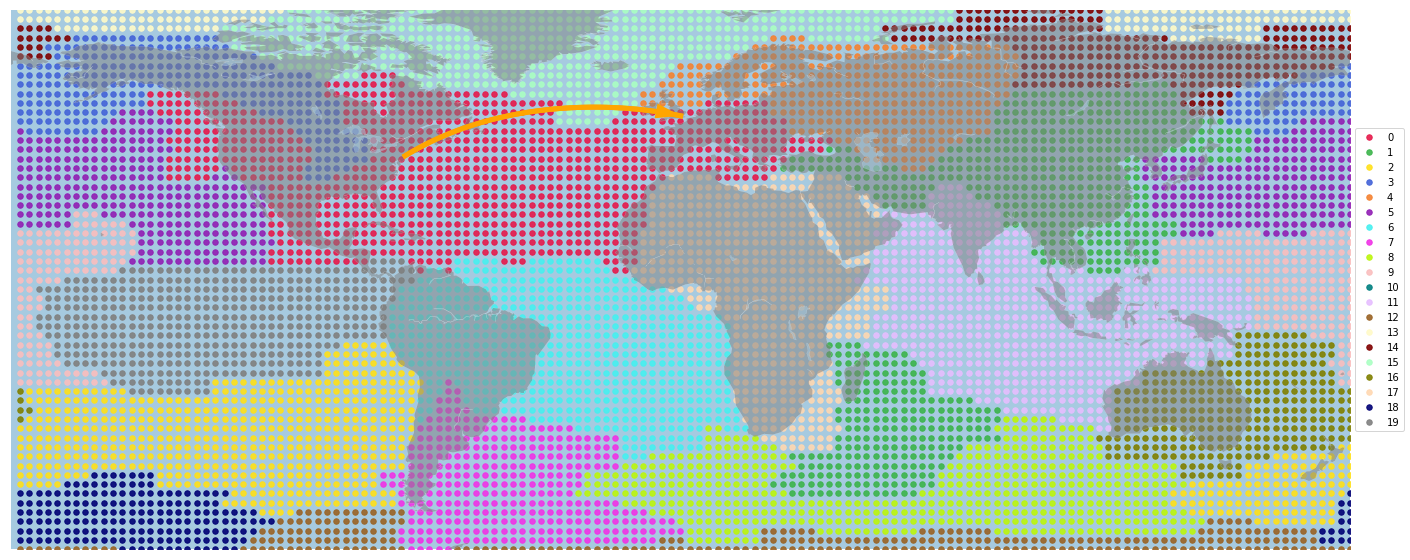

In [53]:

df_list = []
for j in range(n_components_pres):
    df_list.append(pd.DataFrame(columns=df_pres.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")


colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
#colors = pf.random_color(n_components_pres)

for i in range(n_components_pres):
    values = df_pres["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df_pres.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=30, label = i, c = colors[i])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# nylat, nylon are lat/lon of New York
nylat = 40.78; nylon = -73.98
# lonlat, lonlon are lat/lon of London.
lonlat = 51.53; lonlon = 0.08
m.drawgreatcircle(nylon,nylat,lonlon,lonlat, linewidth=5, color='orange')

# grab the great circle, assign a variable for it
gcline, = m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=5,color='orange')
path = gcline.get_path()  # get path from the great circle

head = m(lonlon,lonlat)             # get location of arrow's head (at London)
tail = path.vertices[-2]  # get location of arrow's tail
ax.annotate('',
            xy=(head[0], head[1]), 
            xycoords='data',
            xytext=(tail[0], tail[1]), 
            textcoords='data',
            size=22,
            arrowprops=dict(headwidth=15, \
                            headlength=25, \
                            facecolor="orange", \
                            edgecolor="none", \
                            connectionstyle="arc3, rad=0.001") )

#plt.legend()
plt.show()

In [36]:
path.vertices[-3]

array([-2.63287493, 52.05938162])

# Adding Air temperature (PCA)

In [24]:
air = Data('air.mon.mean.nc','air',temporal_limits, missing_value= -9.96921e+36)

result_air = air.get_data()
lon_air_list = air.get_lon_list()
lat_air_list = air.get_lat_list()
lon_air = air.get_lon()
lat_air = air.get_lat()

result_air = pf.deseasonalize(np.array(result_air))
data_air = pd.DataFrame(result_air)

#result_air = pf.deseasonalize(np.array(result_air))
n_components_air = 10


scale = StandardScaler()
scaled_data = scale.fit_transform(data_air)

pca = PCA(n_components=n_components_air)
pca_model = pca.fit(scaled_data)

Matrix = np.transpose(pca_model.components_)
#Matrix = Matrix/Matrix.sum(axis=0)


loading_air = pd.DataFrame(pf.varimax(Matrix, q=1000))
#loading_air = pd.DataFrame(Matrix)

clusters = loading_air.idxmax(axis=1)
df_air = pd.DataFrame({"lons":lon_air_list,"lats":lat_air_list,"clusters":clusters.values.tolist()})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"].vlues = lon_temp

# Adding Air temperature (Clustering)

In [36]:
n_components_air = 10

air = Data('air.mon.mean.nc','air',temporal_limits, missing_value= -9.96921e+36)

result_air = air.get_data()
lon_air_list = air.get_lon_list()
lat_air_list = air.get_lat_list()
lon_air = air.get_lon()
lat_air = air.get_lat()

result_air = pf.deseasonalize(np.array(result_air))

#temp = pf.deseasonalize(np.transpose(result))
temp = np.array(result_air)
#temp = pf.deseasonalize(result)
clustering = AgglomerativeClustering(n_clusters=n_components_air).fit(np.transpose(temp))

df_air = pd.DataFrame({"lons":lon_air_list,"lats":lat_air_list,"clusters":clustering.labels_})

lon_temp = df_air["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_air["lons"].vlues = lon_temp

cluster_air = []
for i in range(n_components_air):
    Idx = np.where((df_air.clusters == i).values)[0]
    r = result_air[:,Idx]
    #r = pf.deseasonalize(np.array(r))
    data = pd.DataFrame(r)
    scale = StandardScaler()
    scaled_data = scale.fit_transform(data)
    pca = PCA(n_components=n_components_air)
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(data)
    cluster_air.append(pca_data[:,0])

df_cluster_air = pd.DataFrame(np.transpose(np.matrix(cluster_air)))

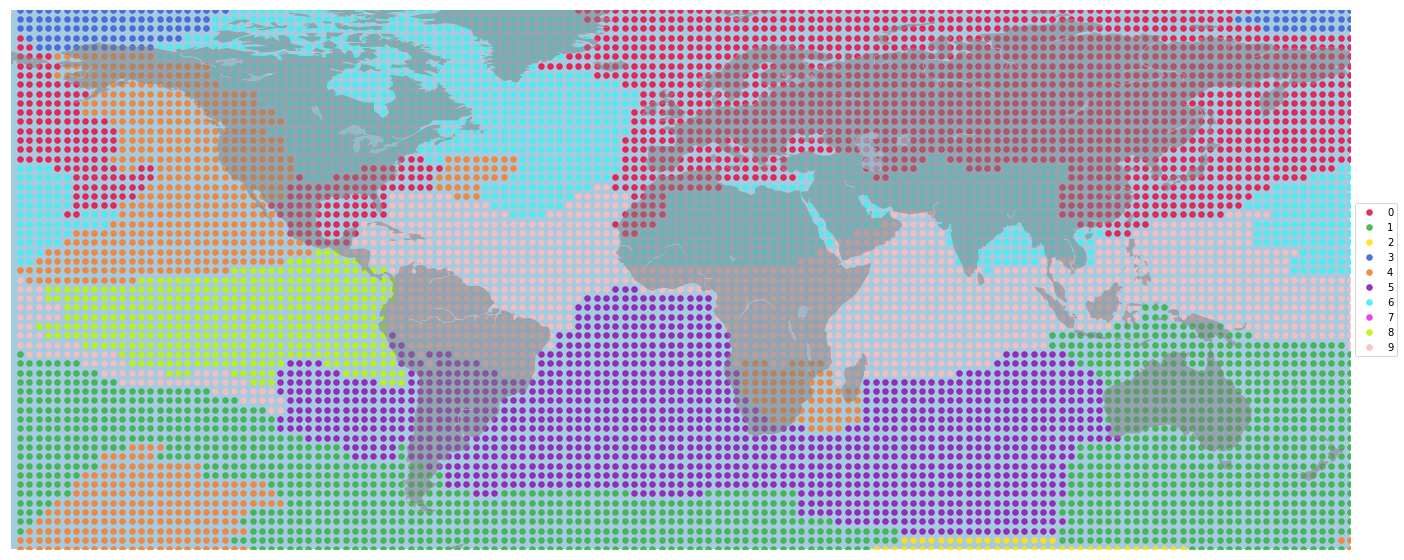

In [37]:
df_list = []
for j in range(n_components_air):
    df_list.append(pd.DataFrame(columns=df_air.columns))

#lon = np.arange(-23.75,60.0,2.5)

fig, ax = plt.subplots(figsize=(30,15))
#fig = plt.figure(figsize=(30,15))
#ax = fig.add_subplot(111)
m=Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
m.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
m.fillcontinents(color='grey', alpha=0.5)
m.drawcoastlines(linewidth=0.1, color="white")

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
'#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', 
'#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']
#colors = pf.random_color(n_components_air)

for i in range(n_components_air):
    values = df_air["clusters"].values  
    Idx = np.where(values == i)[0]
    df_list[i] = df_air.iloc[Idx,:]
    df_list[i]["values"] = values[Idx]

    lons = df_list[i]["lons"].values
    lats = df_list[i]["lats"].values
    x,y = m(lons, lats)
    ax.scatter(x, y, alpha=0.9, s=30, label = i, c = colors[i])
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
#plt.legend()
plt.show()

# Discovery of Causality links

In [39]:
pres_name  = []
for i in range(n_components_pres):
    pres_name.append("Pres_%d"%i)

air_name  = []
for i in range(n_components_air):
    air_name.append("Air_%d"%i)

sst_name  = []
for i in range(n_components_sst):
    sst_name.append("SST_%d"%i)

precip_name  = []
for i in range(n_components):
    precip_name.append("Precipitation_%d"%i)

var_names = precip_name + sst_name + air_name + pres_name

result_precip = np.matrix(df_cluster)
#result_sst = result_sst.dot(loading_sst)
#result_air = result_air.dot(loading_air)
#result_pres = result_pres.dot(loading_pres)

result_air = np.matrix(df_cluster_air)
result_sst = np.matrix(df_cluster_sst)
result_pres = np.matrix(df_cluster_pres)


result = np.concatenate((result_precip, result_sst, result_air, result_pres), axis=1)
result = np.matrix(result)

In [40]:
dataframe = pp.DataFrame(result,var_names=var_names)
cond_ind_test = ParCorr()
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test)

In [41]:
results = pcmci.run_pcmci(tau_max=2, pc_alpha=None)

In [42]:
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                                     val_matrix=results['val_matrix'],
                                     alpha_level=0.01)


## Significant links at alpha = 0.01:

    Variable Precipitation_0 has 9 link(s):
        (Precipitation_4 0): pval = 0.00000 | val = 0.335
        (Precipitation_3 0): pval = 0.00000 | val = 0.236
        (SST_19 0): pval = 0.00000 | val = 0.215
        (Precipitation_0 -1): pval = 0.00000 | val = 0.196
        (Pres_8 0): pval = 0.00223 | val = 0.109
        (Pres_9 0): pval = 0.00392 | val = -0.103
        (SST_16 -1): pval = 0.00403 | val = -0.103
        (Pres_7 0): pval = 0.00492 | val = -0.100
        (Air_1 0): pval = 0.00724 | val = 0.096

    Variable Precipitation_1 has 7 link(s):
        (Precipitation_1 -1): pval = 0.00000 | val = 0.217
        (SST_18 0): pval = 0.00069 | val = 0.121
        (SST_8 0): pval = 0.00101 | val = 0.117
        (SST_6 0): pval = 0.00183 | val = 0.111
        (SST_7 -1): pval = 0.00357 | val = -0.104
        (Pres_1 0): pval = 0.00375 | val = -0.103
        (Precipitation_3 0): pval = 0.00522 | val = -0.099

    Variable Precipitation_2 has 15

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0647b6438>)

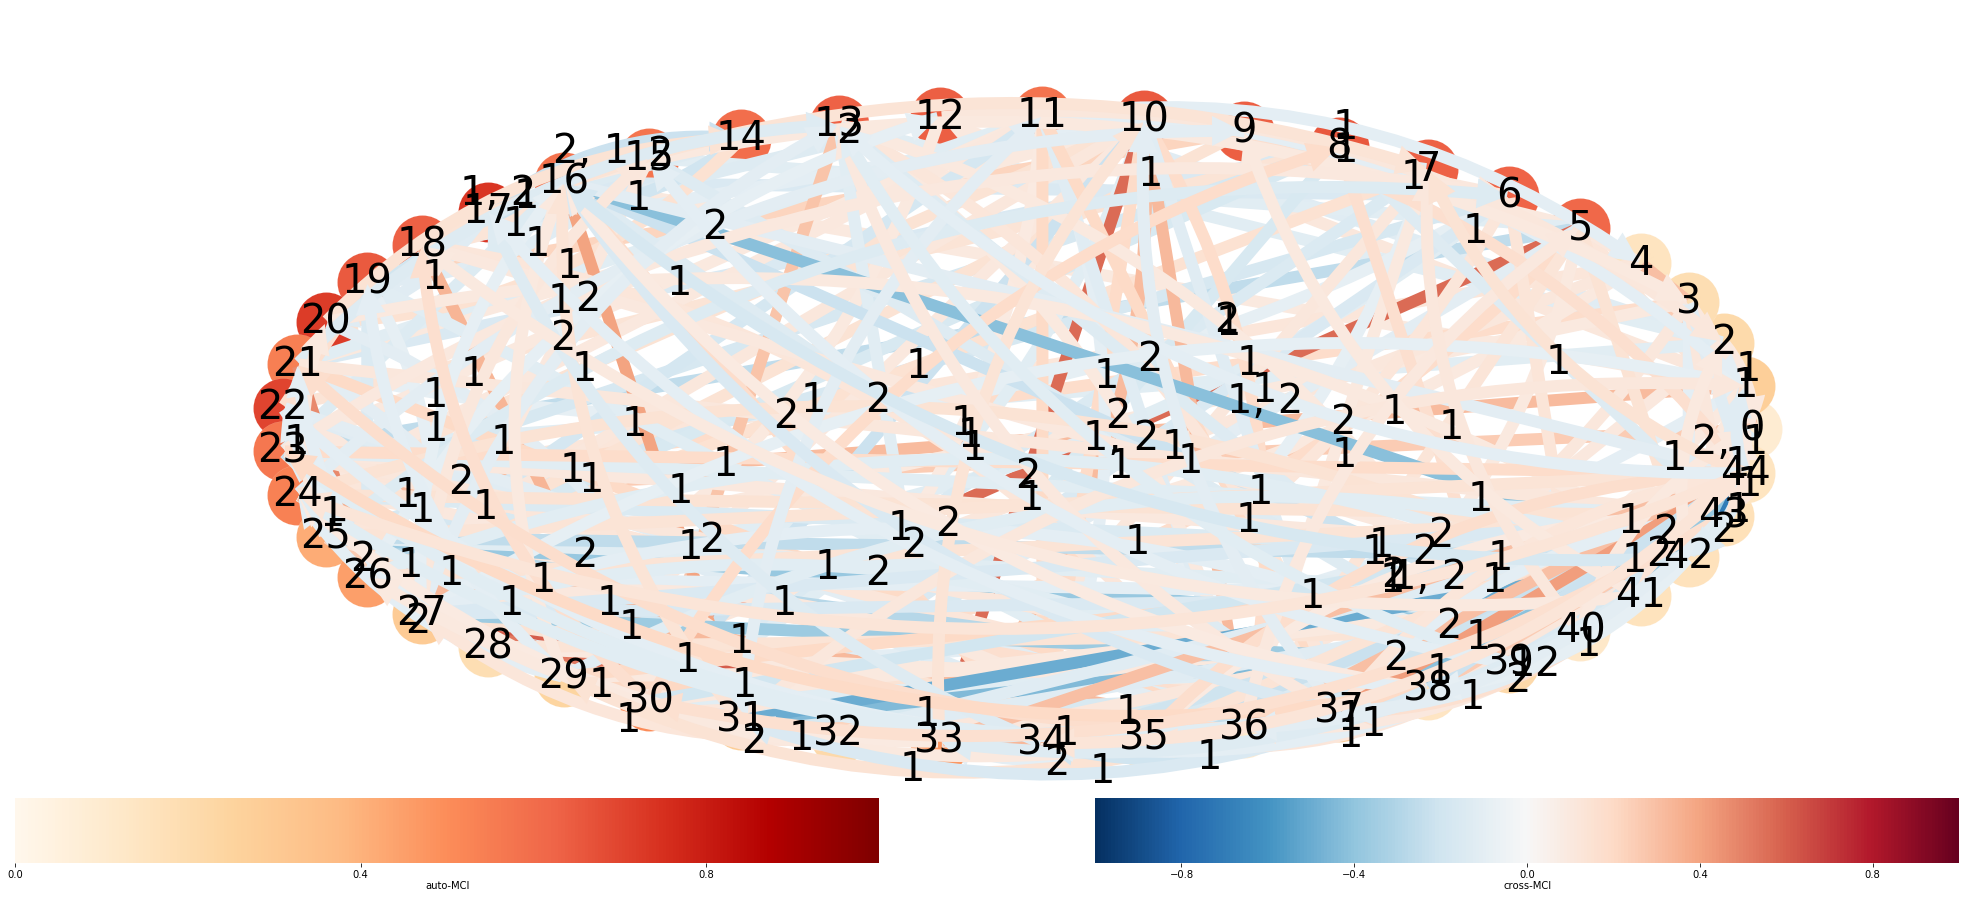

In [43]:
link_matrix = pcmci.return_significant_parents(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 60
    )

In [43]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable Precipitation_0 has 8 link(s):
        (Precipitation_4 0): pval = 0.00000 | qval = 0.00000 | val = 0.335
        (Precipitation_3 0): pval = 0.00000 | qval = 0.00000 | val = 0.236
        (SST_19 0): pval = 0.00000 | qval = 0.00000 | val = 0.215
        (Precipitation_0 -1): pval = 0.00000 | qval = 0.00000 | val = 0.196
        (Pres_8 0): pval = 0.00223 | qval = 0.00223 | val = 0.109
        (Pres_9 0): pval = 0.00392 | qval = 0.00392 | val = -0.103
        (Pres_7 0): pval = 0.00492 | qval = 0.00492 | val = -0.100
        (Air_1 0): pval = 0.00724 | qval = 0.00724 | val = 0.096

    Variable Precipitation_1 has 6 link(s):
        (Precipitation_1 -1): pval = 0.00000 | qval = 0.00000 | val = 0.217
        (SST_18 0): pval = 0.00069 | qval = 0.00069 | val = 0.121
        (SST_8 0): pval = 0.00101 | qval = 0.00101 | val = 0.117
        (SST_6 0): pval = 0.00183 | qval = 0.00183 | val = 0.111
        (Pres_1 0): pval = 0.00375 | qval 

(<Figure size 2160x1080 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe0622a4b38>)

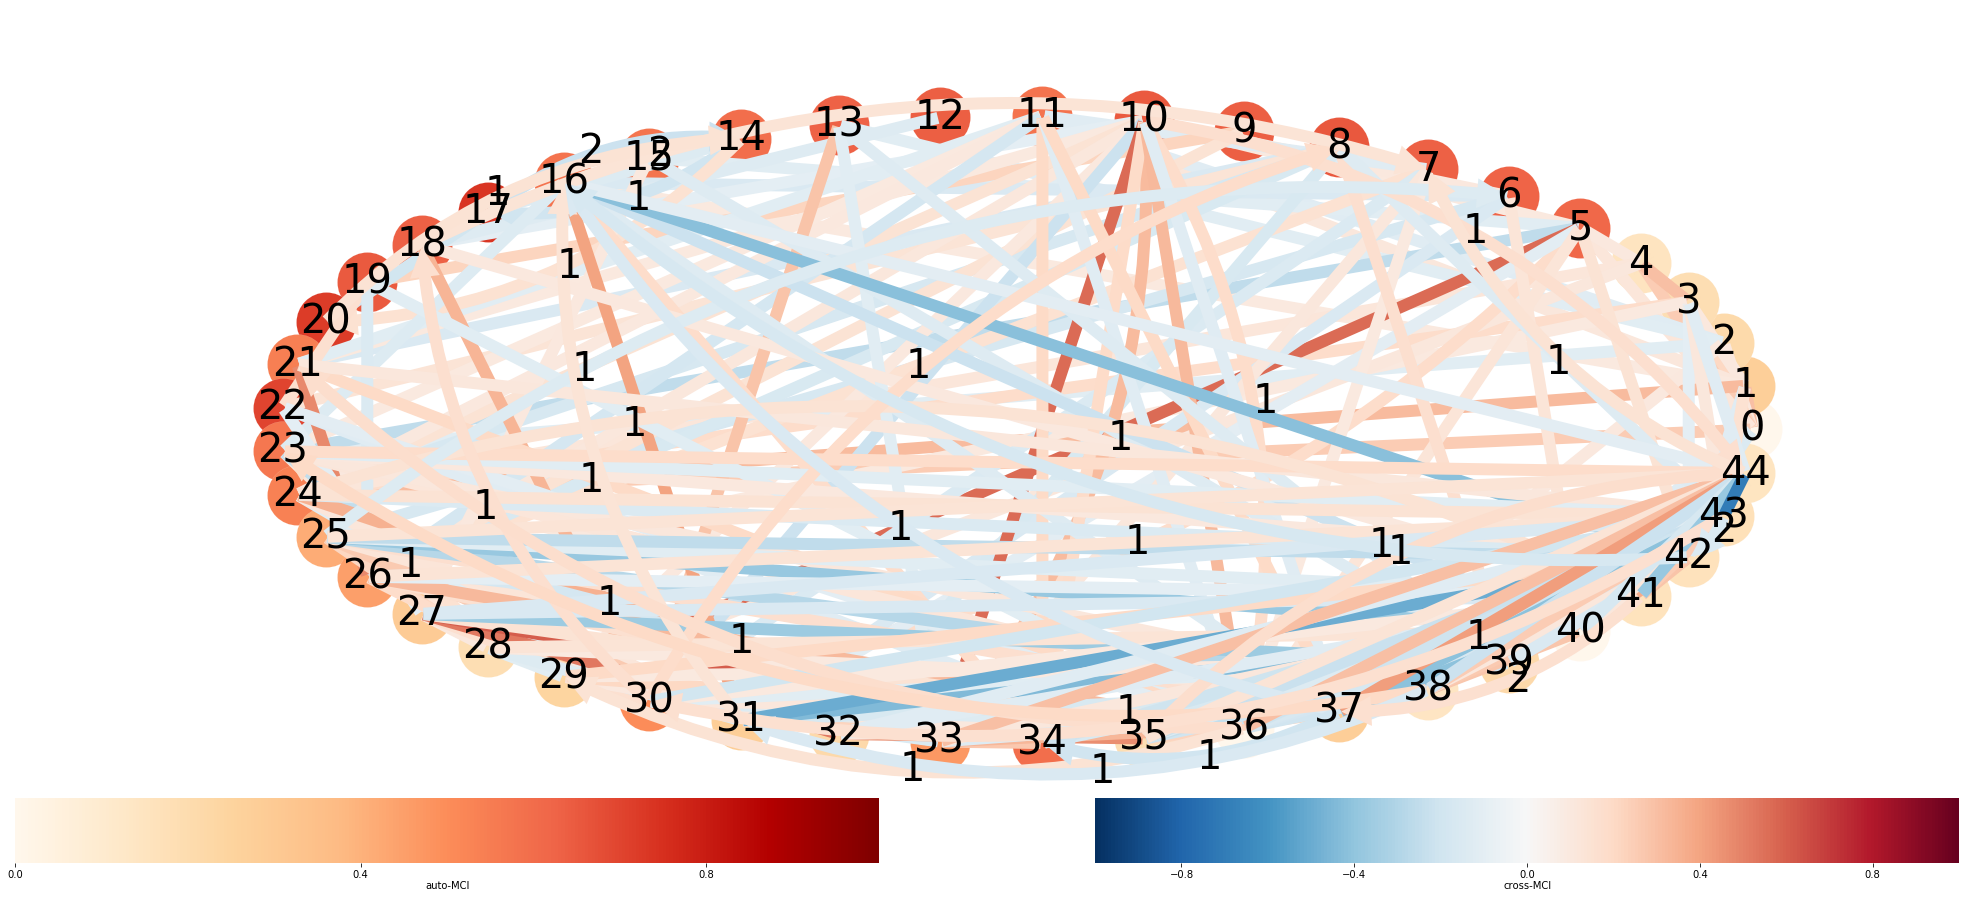

In [45]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',figsize=(30,15),
    node_label_size=40,
    link_label_fontsize = 40,
    node_size = 60,
    arrow_linewidth = 60
    )